# Lovely spam - Building a naive Bayes spam filter

`category: intermediate probability, machine learning classification`

<img src="imgs/spam.jpg" width=750 height=680 />

## Introduction and project's goal

In this project, we're going to **build a spam filter using a multinomial** [naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).<br/>
Spam is nowadays practically eveywhere: emails, phone sms, internet forums, socials. These unrequested messages are at best annoying, but may also constitute a threat (e.g. sending malicious links).

Here, we're going to focus on a **spam filter for sms**. In our intentions, the filter would analyse the words that constitutes the message and tell us "probably it's spam", "probably it's not spam" or "I'm uncertain".
For that, we'll use a dataset that you can download at the famous [UCI repository for Machine Learning](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The authors built a collection of 5572 spam and non-spam (**ham** from now on) messages taken from different sources.

The project's goal is to reach **at least 80% accuracy** in the classification (more on accuracy later).

## What is a Naive Bayes classifier?

Naive Bayes (nB) classifiers are a class of simple algorithms which allow to compute the probability for one set of features (e.g. words) to belong to a particular class. This is possible by means of the **Bayes' theorem**. They classify a given set of features by selecting the class with the highest associated probability.<br/>
In their basic form, they are fast to train because their computational cost varies linearly with the number of features, and at run-time they require to only look up a table of already computed probabilities and perform some multiplications.

In our case, we want to calculate the probability for one particular message containing the $n$ words $\{w_{1}, w_{2}, ... w_{n}\}$ to be a spam or a ham message. In symbols (and using the Bayes' theorem):

$$P(spam|\{w_{1}, w_{2}, ... w_{n}\}) \propto P(spam)\cdot P(\{w_{1}, w_{2}, ... w_{n}\}|spam)$$ 

$$P(ham|\{w_{1}, w_{2}, ... w_{n}\}) \propto P(ham)\cdot P(\{w_{1}, w_{2}, ... w_{n}\}|ham)$$

Now for the naiveness: in order to simplify the calculations, we make the assumption of **conditional independence**, i.e. we assume that the probability of each word to be in a spam/ham message is not influenced by the presence of the others. This way, the $P(\{w_{1}, w_{2}, ... w_{n}\}|spam)$ splits into the product of $n$ terms, like:

$$P(spam|\{w_{1}, w_{2}, ... w_{n}\}) \propto P(spam) \prod_{i=1}^{n}P(w_{i}|spam)$$

$$P(ham|\{w_{1}, w_{2}, ... w_{n}\}) \propto P(ham) \prod_{i=1}^{n}P(w_{i}|ham)$$

$P(spam)$ and $P(ham)$ are simply the fraction of spam and ham messages in the dataset.<br/> 
We're going to calculate the probabilities for the i-th word as:

$$P(w_{i}|spam) = \frac{N_{w_{i}|spam} + \alpha}{N_{spam} + \alpha N_{voc}}$$

$$P(w_{i}|ham) = \frac{N_{w_{i}|ham} + \alpha}{N_{ham} + \alpha N_{voc}}$$

where:
- $N_{w_{i}|spam}$ is the number of times the word $w_{i}$ appears in the spam messages, counting each istance separately;
- $N_{spam}$ is the number of words in all spam messages, again counting repeated words as separate contributions;
- $N_{voc}$ is the number of unique words which appear in spam and ham words, a set which we'll call the  **vocabulary**;
- $\alpha$ is a parameter used for additive smoothing (i.e. avoiding that a probability for a word be zero if it doesn't appear in the vocabulary).

The remaining terms have similar meaning.


Two important observations to end our theoretical introduction:
- the conditional independence assumption is a very strong one and it's not always guaranteed that it holds. Nonetheless, the nB classifier often gives good results even when this assumption formally fails;
- the proportionality symbol $\propto$ means that the formulas don't give the actual probability, but a quantity proportional to it. This is fine, because we're interested in **comparing** probabilities, not calculating their actual values.

## Summary of results

- The accuracy of the model on the test set is **98.7%**, much higher than our 80% initial goal.
- Making the model more complicated by including sensitivity to letter case is of no help.
- We found that spammers indeed use techniques to try and deceive the spam filters, and that probably explains the 14 misclassified sms (out of 1114). 

### Modules we need

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

## Getting to know the dataset

Let's load the dataset into a Pandas dataframe called `data`:

In [2]:
# o.s. independent path to the dataset
path_to_dataset = os.path.join(os.curdir, 'datasets', 'sms_spam_collection', 'dataset') 

data = pd.read_csv(path_to_dataset, 
                   sep='\t',
                   header=None,
                   names=['Label', 'SMS'])

In [3]:
data.head(5)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We see that the dataset is very simple: each row corresponds to a sms with its **label** (either spam or ham).

In [4]:
data.info()
print('\n')
print(f'The dataset contains {data.shape[0]} sms and no null values.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


The dataset contains 5572 sms and no null values.


In the next cell we plot the relative frequency of spam and ham messages in the dataset.<br/> 
We see that most of the sms are legitimate messages.

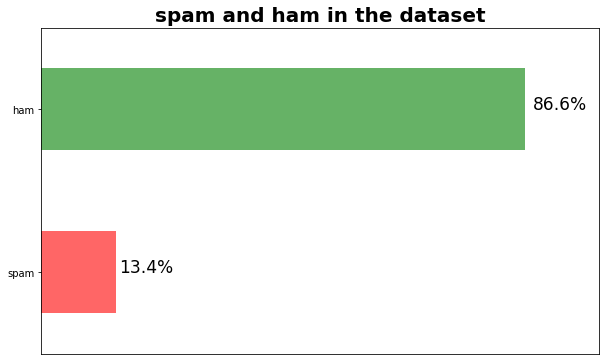

In [5]:
fig, ax = plt.subplots(figsize=(10,6))

# data for the plot
label_counts = data['Label'].value_counts(normalize=True) * 100
# drawing the barplot
label_counts.plot.barh(ax=ax, color=['g', 'r'], alpha=0.6)

# customize the plot
ax.invert_yaxis()
ax.set_title('spam and ham in the dataset', fontsize=20, weight='bold')
ax.text(14, 1, str(round(label_counts['spam'], 1)) + '%', fontsize=17)
ax.text(88, 0, str(round(label_counts['ham'], 1)) + '%', fontsize=17)
ax.set_xlim(0,100)
ax.tick_params(axis='x', bottom=False, labelbottom=False)

plt.show()

## Training and test datasets

We're going to split the data in a **training** set on which the parameters of the model will be calculated and a **test** set on which we'll measure how well the model behaves on data it has never seen.<br/>
The proportions will be 80% for the training set and 20% for the test set, i.e.:

In [6]:
print('Training:', round(data.shape[0] * 0.8), 'messages')
print('Test:\t ', round(data.shape[0] * 0.2), 'messages')

Training: 4458 messages
Test:	  1114 messages


In [7]:
# shuffle the dataset to guarantee spam and ham are spread uniformly
shuffled = data.sample(frac=1, random_state=1)

# create the training and test sets
train = shuffled.iloc[:4458].reset_index(drop=True).copy()
test = shuffled.iloc[4458:].reset_index(drop=True)

Let's verify that spam and ham have the same proportions of the original dataset both in `train` and `test` dataframes.

In [8]:
train['Label'].value_counts(normalize=True) * 100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [9]:
test['Label'].value_counts(normalize=True) * 100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

Yep, pretty much! We can start the data cleaning/wrangling phase.

## Data cleaning and preprocessing

Before we can actually calculate the parameters of the model, we must clean and wrangle the data a bit so that their format is appropriate. These are the first three messages in the training set:

In [10]:
train.head(3)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired


In the next cell, we will define a function for removing the punctuation from a message. The function will also have a parameter `case_sensitive` through which we can control if the words in the message are lower-cased or not.<br/>
Then we will split each sms into a list of its words.<br/>
Finally, we will obtain the **vocabulary**, i.e. the list of all the unique words which appear in the train set.

In [11]:
def clean_sms_text(sms, case_sensitive=False):
    '''Take one sms string and return the same string with
       punctuation removed and (if case_sensitive==False) lowercased letters'''
        
    if not case_sensitive:        
        return re.sub(r'\W', ' ', sms).lower()
    else:
        return re.sub(r'\W', ' ', sms)

# apply the function to the SMS column    
train['SMS'] = train['SMS'].apply(clean_sms_text)
# obtain the list of words
train['SMS'] = train['SMS'].str.split()

# building the vocabulary
vocabulary = []
for words_list in train['SMS']:
    for word in words_list:
        vocabulary.append(word)

vocabulary = list(set(vocabulary))    

In [12]:
print(f'The vocabulary has {len(vocabulary)} words.')

The vocabulary has 7783 words.


The last step in the cleaning phase will be to count how many times each word in the dictionary appears in each message. In other terms, we want to obtain something like:

<img src="imgs/final_df_naive_bayes.png" width=500 height=350 />
<!-- <p style="text-align: center;">Pitcairn islanders in 1916</p> -->

In [13]:
# initialize the dictionary
word_counts_per_sms = {word: [0] * len(train['SMS']) for word in vocabulary}

# count the occurrence of each word for each sms
for i, sms in enumerate(train['SMS']):
    for word in sms:
        word_counts_per_sms[word][i] += 1
        
# transform into a dataframe and concatenate with the training set
counts_df = pd.DataFrame(word_counts_per_sms)
train = pd.concat([train, counts_df], axis=1)

Let's take a look at what we got:

In [14]:
train.head(3)

,Label,SMS,mustprovide,82050,fulfil,8p,slots,08718727868,formatting,quarter,...,yours,urgnt,langport,blankets,poortiyagi,worry,jus,freely,123,meaningful
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the model parameters

We are finally ready to calculate the model parameters. We'll start from the costants (refer to the initial paragraph `What is a Naive Bayes classifier?` for reviewing their meaning).

They are: $P(spam)$, $P(ham)$, $N_{spam}$, $N_{ham}$, $N_{voc}$. The parameter $\alpha$ will be set to 1.

In [15]:
def model_constant_parameters(train_dataset):
    '''Return a tuple with all the constant parameters of the nB model'''
    
    # P(Spam) and P(Ham)
    p_spam = train_dataset['Label'].value_counts(normalize=True)['spam']
    p_ham = train_dataset['Label'].value_counts(normalize=True)['ham']

    # number of words in spam, ham messages and unique words
    n_spam = train_dataset[train_dataset['Label'] == 'spam']['SMS'].apply(len).sum()
    n_ham = train_dataset[train_dataset['Label'] == 'ham']['SMS'].apply(len).sum()
    n_vocabulary = len(vocabulary)

    # Laplace smoothing
    alpha = 1
    
    return (p_spam, p_ham, n_spam, n_ham, n_vocabulary, alpha)

In [16]:
p_spam, p_ham, n_spam, n_ham, n_vocabulary, alpha = model_constant_parameters(train)

The last step is to calculate the probability $P(w_{i})$ for each word, both in ham and spam messages.

In [17]:
def model_variable_parameters(train_dataset):
    '''Return two dictionaries with the probabilities of each word
       being spam or ham'''
    
    # initialize the two dictionaries
    prob_given_spam = {word: 0 for word in vocabulary}
    prob_given_ham = {word:0 for word in vocabulary}

    # spam messages probabilities
    train_dataset_spam = train_dataset[train_dataset['Label'] == 'spam'].iloc[:, 2:]
    for word in train_dataset_spam.columns:
        prob_given_spam[word] = (train_dataset_spam[word].sum() + alpha) / (n_spam + alpha * n_vocabulary)

    # ham messages probabilities
    train_dataset_ham = train_dataset[train_dataset['Label'] == 'ham'].iloc[:, 2:]
    for word in train_dataset_ham.columns:
        prob_given_ham[word] = (train_dataset_ham[word].sum() + alpha) / (n_ham + alpha * n_vocabulary) 
        
    return (prob_given_spam, prob_given_ham)    

In [18]:
prob_given_spam, prob_given_ham = model_variable_parameters(train)

## Classifying new messages

Now that all the parameters have been calculated, we are ready to apply the model to new messages.<br/>
The function defined in the next cell will clean the message before classifying it.

In [19]:
def classify(message: str, case_sensitive=False) -> str:
    '''Take a new message, perform some cleaning and calculate the 
       probabilities it's spam or ham.
       Return "spam", "ham" or "uncertain" as classification.'''
    
    if not case_sensitive:
        cleaned_msg = re.sub(r'\W', ' ', message).lower()
    else:
        cleaned_msg = re.sub(r'\W', ' ', message)
    msg_words = cleaned_msg.split()
    
    # calculate the probabilities with the model
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in msg_words:
        p_spam_given_message *= prob_given_spam.get(word, 1)
        p_ham_given_message *= prob_given_ham.get(word, 1)
        
    # classification
    if p_spam_given_message > p_ham_given_message:
        return 'spam'
    elif p_spam_given_message < p_ham_given_message:
        return 'ham'
    else:
        return 'uncertain'

We quickly try the function on two messages:

In [20]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

'spam'

In [21]:
classify("Sounds good, Tom, then see u there")

'ham'

## Measuring the accuracy on the test set

Let's now verify that the model does a good job on messages it has never seen.<br/> 
For this, we will apply the classification algorithm to each message of the test set (1114 sms).<br/>

The **accuracy** of the model is simply measured as:

$$Accuracy = \frac{no.\:of\:correctly\:classified\:messages}{no.\:of\:classified\:messages}$$

In [22]:
test['predicted_label'] = test['SMS'].apply(classify)

correct = (test['Label'] == test['predicted_label']).sum()            
accuracy = correct / len(test)

print(f'The model has an accuracy of {(accuracy * 100):.1f}% over the test set.')

The model has an accuracy of 98.7% over the test set.


We reached a higher accuracy than our initial goal (80%): 
1100 messages were correctly classified out of 1114.

Our spam filter definitely works.

### Uncorrectly classified messages: why?

We're curious to try and have an intuition for the reasons of misclassification. Let's take a look at those messages.

In [23]:
# misclassified sms
uncorrect_sms = test[test['Label'] != test['predicted_label']]

In [24]:
# print the spam messages classified as ham
for i, row in uncorrect_sms[uncorrect_sms['predicted_label'] == 'ham'].iterrows():
    print(row['SMS'])
    print('-' * 20)

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
--------------------
More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB
--------------------
Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
--------------------
Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text
--------------------
0A$NETWORKS allow companies to bill for SMS, so they are responsible for their "suppliers", just as a shop has to give a guarantee on what they sell. B. G.
--------------------
RCT' THNQ Adrian for U text. Rgds Vatian
--------------------
2/2 146tf150p
--------------------
Hello. We need some posh birds and chaps to user trial prods

It seems that these messages passed through the filter because most of them are long and mostly composed of common words. Furthermore, sometimes abbreviations and deliberate typos (like "xafter" instead of "after") are used, so that those words are simply skipped in the calculation.

In [25]:
# print the ham messages classified as spam
for i, row in uncorrect_sms[uncorrect_sms['predicted_label'] == 'spam'].iterrows():
    print(row['SMS'])
    print('-' * 20)

Unlimited texts. Limited minutes.
--------------------
26th OF JULY
--------------------
Nokia phone is lovly..
--------------------
No calls..messages..missed calls
--------------------
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
--------------------


On the other hand, four of these messages are very short and thus just one or two words appearing in the spam class and not in the ham class are enough to jump to the wrong conclusion.

## What happens if the model becomes case-sensitive?

In the next cell we will repeat all the previous steps on the training and test sets, but this time we will **not** convert all the letters to lower case, i.e. the model will be case-sensitive. We're curious to see if the accuracy changes.

In [26]:
# recreate the training and test sets
shuffled = data.sample(frac=1, random_state=1)
train = shuffled.iloc[:4458].reset_index(drop=True).copy()
test = shuffled.iloc[4458:].reset_index(drop=True)

# each sms gets splitted into a list of words
train['SMS'] = train['SMS'].apply(clean_sms_text, case_sensitive=True)
train['SMS'] = train['SMS'].str.split()

# building the vocabulary
vocabulary = []
for words_list in train['SMS']:
    for word in words_list:
        vocabulary.append(word)

vocabulary = list(set(vocabulary))

In [27]:
# initialize the dictionary
word_counts_per_sms = {word: [0] * len(train['SMS']) for word in vocabulary}

# count the occurrence of each word for each sms
for i, sms in enumerate(train['SMS']):
    for word in sms:
        word_counts_per_sms[word][i] += 1
        
# transform into a dataframe and concatenate with the training set
counts_df = pd.DataFrame(word_counts_per_sms)
train = pd.concat([train, counts_df], axis=1)

In [28]:
# calculate the model parameters
p_spam, p_ham, n_spam, n_ham, n_vocabulary, alpha = model_constant_parameters(train)
prob_given_spam, prob_given_ham = model_variable_parameters(train)

# classify the test-set sms 
test['predicted_label'] = test['SMS'].apply(classify, case_sensitive=True)

# measure the accuracy
correct = (test['Label'] == test['predicted_label']).sum()            
accuracy = correct / len(test)
print(f'The model has an accuracy of {(accuracy * 100):.1f}% over the test set.')

The model has an accuracy of 97.7% over the test set.


We see that making the model case-sensitive slightly worsens its performance.

## Conclusions

In this project, we built a naive Bayes spam filter for sms and managed to correctly classify 98.7% of the sms in the test-set.<br/>
We tried to explain in a qualitative way the reason for misclassification, which is probably unavoidable with our basic approach.<br/>
Finally, we found that making the model case-senitive didn't improve its performance.